# INTRO

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn import preprocessing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [3]:
# Read and view TR
# dataset = "cup/ML-CUP20-TR.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TR.csv"

# Column 0:     ID
# Column 1-10:  inputs
# Column 11-12: target_x target_y
train_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
               "input_10", "target_x", "target_y"]
df_train = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=train_names, index_col=0))

# Store the number of training patterns
n_TR_patterns = len(df_train.index)
print(f'N. rows TR: {n_TR_patterns}\n')

# log.write(f'N. rows TR: {n_TR_patterns}\n')

# print(df_train.head())

# Read and view TS
# dataset = "cup/ML-CUP20-TS.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TS.csv"

# Column 0:    ID
# Column 1-10: inputs
test_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
              "input_10"]
df_test = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=test_names, index_col=0))

# Store the number of (blind) testing patterns
n_TS_patterns = len(df_test.index)
print(f'N. rows TS: {n_TS_patterns}\n')

N. rows TR: 1524

N. rows TS: 472



In [4]:
# Divide into TR and (internal) TS
attributes = [col for col in df_train.columns if 'input' in col]

# Separating internal TS from the rest of training dataset (Hold out ca. 20%)
print("\ndf_train ", len(df_train))  # 1524

df_subset = df_train.sample(304, random_state=100)
print("\ndf_subset ", len(df_subset))  # 304
print(df_subset.head())

df_train = df_train.drop(df_subset.index)
print("\ndf_train after removal ", len(df_train))  # 1220

X_train = df_train[attributes].values
y_train = df_train[['target_x', 'target_y']].values

X_test = df_subset[attributes].values
y_test = df_subset[['target_x', 'target_y']].values

n_features = X_train.shape[1]
print(X_train.shape[0])

print(f'\nN. input features: {n_features}')

# log.write(f'\nN. input features: {n_features}')

# Handle (blind) TS
attributes = [col for col in df_test.columns if 'input' in col]
X_blind_TS = df_test[attributes].values


df_train  1524

df_subset  304
       input_1   input_2   input_3  ...  input_10   target_x   target_y
id                                  ...                                
801   1.155300  0.059795 -0.604900  ...  1.727382  39.929663 -29.595517
720  -0.918605  0.637450  1.347002  ... -0.903759  72.384610 -28.855841
1059 -0.652593  1.394323  0.103282  ... -1.030427  52.796461 -39.445597
189   1.439956 -0.605409 -0.758339  ...  1.819379  40.553341 -30.551312
229   0.915644 -1.250489 -1.028318  ...  0.055362  31.467524 -13.706777

[5 rows x 12 columns]

df_train after removal  1220
1220

N. input features: 10


# RANDOM FOREST

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from keras import backend as K

def mee_keras(y_true, y_pred):
  return K.mean(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True)))

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

#GRID SEARCH

In [8]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [35,45,40],
    'min_samples_leaf': [1],
    'min_samples_split': [2,30],
    'max_features': [4],
    'n_estimators': [300,310,320]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [9]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   40.8s finished


In [10]:
best_grid

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=45, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

cross validation + test 

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_grid, X_train, y_train, cv=3)

print("Mean R2 with cross-validation: ", scores.mean())

Mean R2 with cross-validation:  0.9510504797599321


R2 on test set:  0.9558915797401363
MSE on test set:  7.407862702249733
MEE on test set:  2.9513004005782806


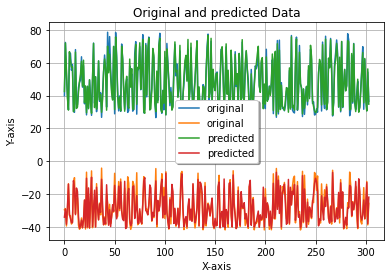

In [12]:
ypred = best_grid.predict(X_test)

score = best_grid.score(X_test, y_test)
print("R2 on test set: ", score)

mse = mean_squared_error(y_test, ypred)
mee = mee_keras(y_test, ypred)
print("MSE on test set: ", mse)
print("MEE on test set: ", float(mee))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Original and predicted Data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()   